# Pairing Phenology Data with Invasive Species Data
## Deena Bleich BIOF309 Fall 2018

### This program maps the spread of invasive species over the years. It shows the geographical relationship of the destructive invasive species to host plants.

---

## Citizen Science Phenology data was used to obtain the host species geographical information 


### Phenology is the study of cyclic and seasonal natural events in the life of plants and animals.

#### Sources of Phenology data:
- Citizen science
- Government and non-profit organizations
- Historic data – old diaries, field notes


Source of Phenology data for this project:
    USA National Phenology Network (NPN) --
    Nature’s Notebook – Citizen Science
    
   https://www.usanpn.org/data/observational

 It was filtered for a certain type of tree (ex. Ash) and the file was downloaded.
 
 ---

## Retrieving, formatting and analyzing the invasive species data

- Retrieved from EDDMapS. 2018. Early Detection & Distribution Mapping System. The University of Georgia - Center for Invasive Species and Ecosystem Health. Available online at http://www.eddmaps.org/
- Needed to be matched with Lat/Long by county - https://www.gaslampmedia.com/download-zip-code-latitude-longitude-city-state-county-csv/
- And with State abbreviations - https://scottontechnology.com/list-of-50-us-states-in-excel/

---

## Visualizing the data

- Used Basemap to draw the map 
    - Reference: http://geodesygina.com/matplotlib.html
- Installing basemap was a challenge
    - Found help on Stack Overflow website 
    - Use Anaconda Prompt
    - conda install -c conda-forge basemap-data-hires=1.0.8.dev0
---


Ash Trees and the Emerald Ash Borer

“Emerald ash borer (EAB), *Agrilus planipennis* Fairmaire, is an exotic beetle that was discovered in southeastern Michigan near Detroit in the summer of 2002. The adult beetles nibble on ash foliage but cause little damage. The larvae (the immature stage) feed on the inner bark of ash trees, disrupting the tree's ability to transport water and nutrients. Emerald ash borer probably arrived in the United States on solid wood packing material carried in cargo ships or airplanes originating in its native Asia. As of February 2018, it is now found in 32 states, and the Canadian provinces of Ontario, Quebec, and Manitoba.”
Source: http://emeraldashborer.info/

---

Hemlocks and the Hemlock Woolly Adelgid

Hemlock woolly adelgid was inadvertently introduced to North America from Japan. It was first noticed in the eastern United States near Richmond, Virginia, in 1951. (https://en.wikipedia.org/wiki/Hemlock_woolly_adelgid)

However, the invasive species data that I have retrieved from the EDD site starts in 2004.

---


In [1]:
def tree_scatter(df_tree, plant_species):
    """
    A very simple scatter diagram that displays which states have these plant species.
    """
    
    import pandas as pd 
    import matplotlib.pyplot as plt

    plt.style.use('ggplot')
    plt.figure(figsize=(12,8))
    plt.scatter(df_tree.State, df_tree.Common_Name)
    plt.title('States where {0} were observed'.format(plant_species))
    plt.xlabel('States')
    plt.ylabel('Species')
    plt.show()

In [5]:
def invasives(tree_dataset, 
              invasive_dataset,
              state_abbr_dataset,
              lat_long_for_county_dataset,
              plant_species_name,
              start_year,
              end_year,
              year_interval):

    """
    This program maps the spread of invasive species over the years.
    It shows the geographical relationship of the invasive species to host plants.

    @author: Deena Bleich
    """

    import pandas as pd 
    import matplotlib.pyplot as plt
    from mpl_toolkits.basemap import Basemap
 
    %matplotlib inline

    """ 
    Read the tree species data into a Pandas DataFrame.
    
    The tree species data was downloaded from the USA National Phenology Network (NPN) 
    at https://www.usanpn.org/data/observational.
    This data was citizen science phenology observations collected through the Nature's Notebook program.
    (2009 to the present in the USA)
    """
    try:
        df_tree = pd.read_csv(tree_dataset)
        df_tree = df_tree[df_tree.State != '-9999'] #Remove records with unknown states
    except:
        print("The file {0} was not found or could not be read".format(tree_dataset))
        return
    
    plant_species_id_list = list(df_tree.Species_ID.unique()) #Create a list of all the species in the dataset.

    """
    Make a simple scatter diagram to gather information
    """
    #tree_scatter(df_tree, plant_species_name)

    """ 
    Read the invasive species data into a Pandas DataFrame.
    
    The invasive species data was downloaded from http://www.eddmaps.org.
    The Early Detection & Distribution Mapping System. (EDDMapS, 2018) 
    The University of Georgia - Center for Invasive Species and Ecosystem Health.
    """ 
    try:
        df_invasive = pd.read_excel(invasive_dataset)
    except:
        print("The file {0} was not found or could not be read".format(invasive_dataset))
        return

    """
    Some data cleaning was needed: 
    1) Split the Location into city, state, county fields; add County and State columns to df_invasives.
    2) The County field value always has " County" appended. Remove from the County name for later matching with 
    the Lat-Long dataset.
    3) Get the Observation Year from the Observation Date.
    """

    #Split the Location into city, state, county fields; add County and State columns to df_invasives
    df2 = df_invasive[' Location'].str.split(',', expand=True)
    df_invasive['County'] = df2[0].str.strip()
    df_invasive['State'] = df2[1].str.strip()

    #The County field value always has " County" appended. Remove from the County name for later matching.
    df_invasive['County'] = df_invasive['County'].map(lambda x: str(x)[:-7])

    #Get the Observation Year from the Observation Date
    df_invasive.rename(columns={' Observation_ Date': 'Observation_Date'}, inplace=True)
    df_invasive['Observation_Year'] = df_invasive['Observation_Date'].map(lambda x: str(x)[:-15]).apply(pd.to_numeric)

    """
    Many of the records in the Invasives dataset do not have latitude and longitude information. 
    Get the latitude and longitude by matching by county and state with a latitude/longitude dataset.
    """
    
    #Get the State Names and abbreviations
    try:
        statesDf = pd.read_csv(state_abbr_dataset)
    except:
        print("The file {0} was not found or could not be read".format(state_abbr_dataset))
        return
    
    #Merge state abbreviation into master
    df_invasive = pd.merge(df_invasive, statesDf, on= "State", how = "left")
    
    #For the invasive dataset, find the lat/Long using the State abbr.
    try:
        LatLongDf = pd.read_csv(lat_long_for_county_dataset)
    except:
        print("The file {0} was not found or could not be read".format(lat_long_for_county_dataset))
        return
    
    LatLongDf.drop_duplicates(subset=["State_Abbr","County"], keep='first', inplace=True)
    df_invasive = pd.merge(df_invasive, LatLongDf, on= ["State_Abbr","County"], how = "left")

    
    """
    Draw a series of maps.
    1) The first map (Year 2003) only shows the host species.
    2) The next maps show the spread of the invasive species as the years go by.
    """
    
    #Draw a series of maps
    plt.style.use('ggplot')
    
    year = start_year
    while (year < end_year):
    # Define the projection, scale, the corners of the map, and the resolution.   
       plt.figure(figsize=(15,15))
       plt.title("{0} - Year: {1}".format(plant_species_name, year))
    
       m = Basemap(projection='merc',
                   llcrnrlat=20,urcrnrlat=50,
                   llcrnrlon=-130,urcrnrlon=-60,
                   lat_ts=20,
                   resolution='i')
       m.drawcoastlines()
       m.drawcountries()
       m.drawstates()
       m.drawmapboundary()
       m.fillcontinents(color='white', 
                        lake_color='lightblue')
      
        
       # Plot locations of trees
       markers = ('md', 'bv', 'y<', 'g*', 'cs')
        
       for position in range(len(plant_species_id_list)):
    
           df_a_species = df_tree[df_tree.Species_ID == plant_species_id_list[position]]
       
           x,y = m(df_a_species["Longitude"].tolist(), df_a_species["Latitude"].tolist())                            
           m.plot(x,y, 
                  markers[position], 
                  markersize=7, 
                  label=df_a_species["Common_Name"].tolist()[0])
       
       #Get invasive species data before a certain year and plot
       df_invasive_plot = df_invasive[df_invasive.Observation_Year < year] 
       
       x,y = m(df_invasive_plot["longitude"].tolist(), df_invasive_plot["latitude"].tolist())                            
       m.plot(x,y,
              'ro', 
              markersize=5, 
              label=df_invasive[" Common_ Name"].tolist()[0])
    
       #Show the map
       plt.legend()
       plt.show()
    
       #Increase the year for the next map, before returning to the top of the while loop
       year = year + year_interval

C:\Users\Deena\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\Deena\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


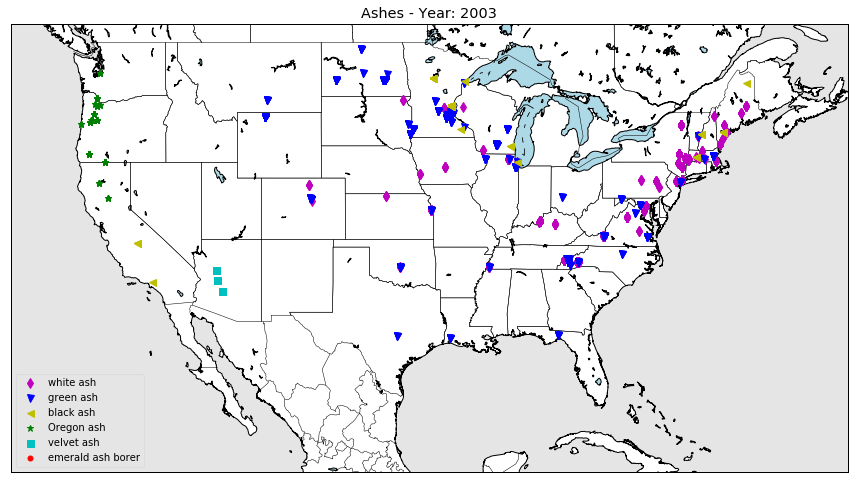

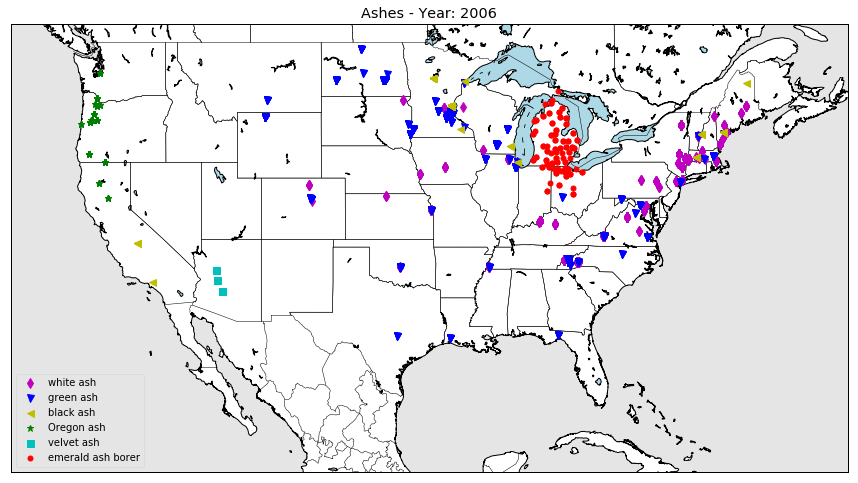

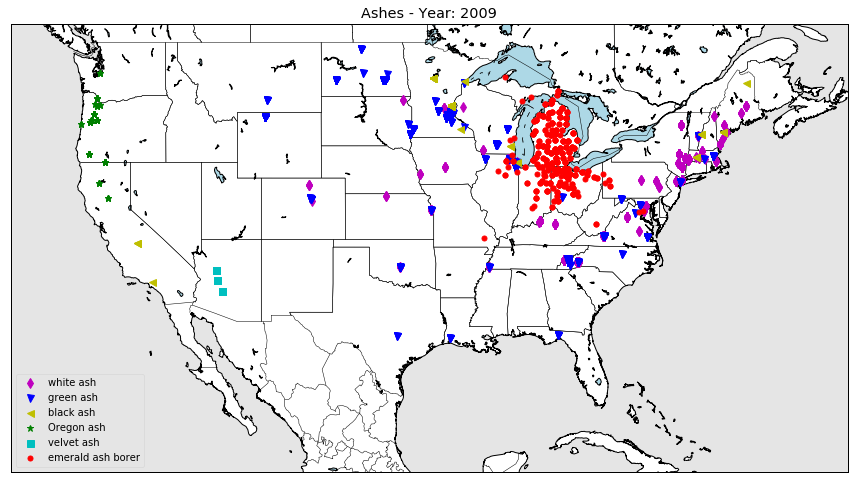

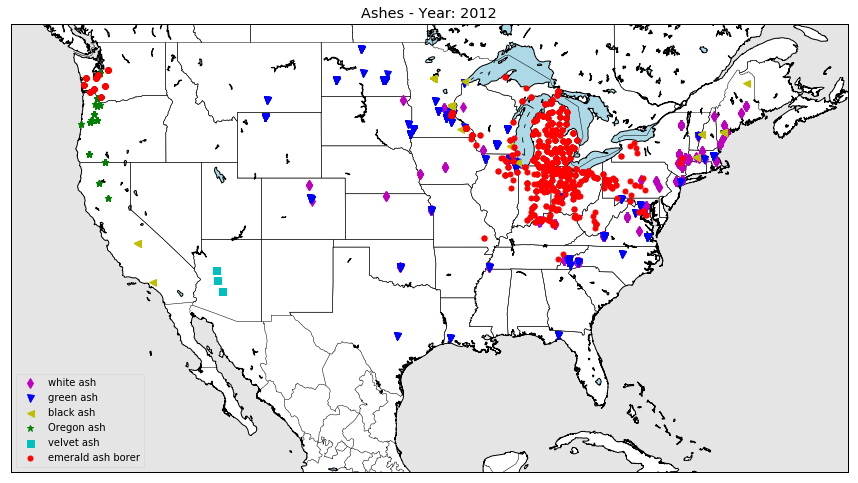

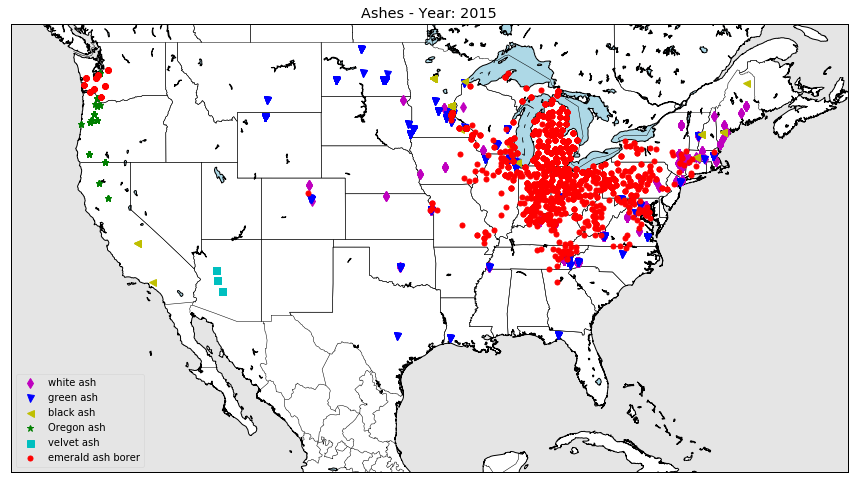

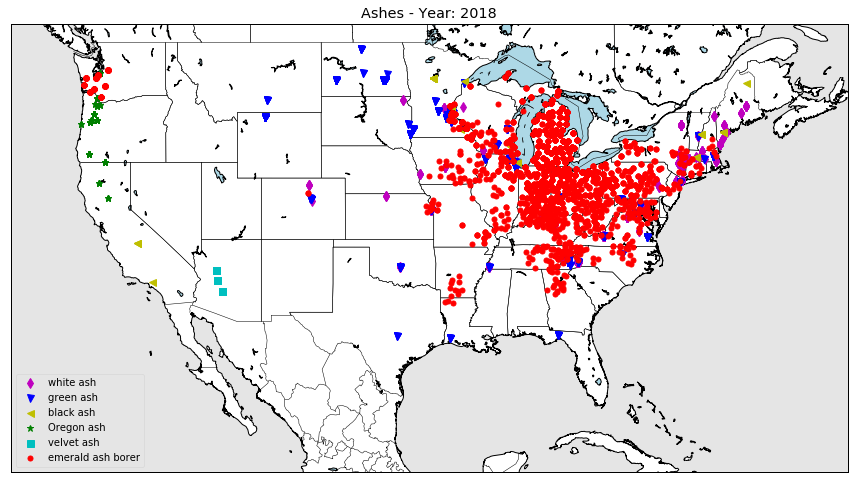

In [6]:
invasives(tree_dataset='fraxinus_data.csv',
          invasive_dataset='ash_borer_data.xlsx',
          state_abbr_dataset='us_states_data.csv',
          lat_long_for_county_dataset='zip_codes_states.csv',
          plant_species_name="Ashes",
          start_year = 2003,
          end_year = 2019,
          year_interval = 3)

C:\Users\Deena\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\Deena\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


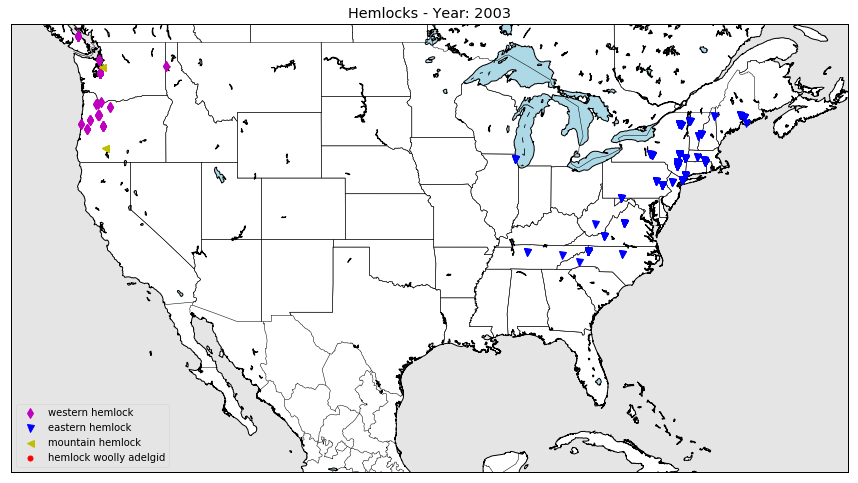

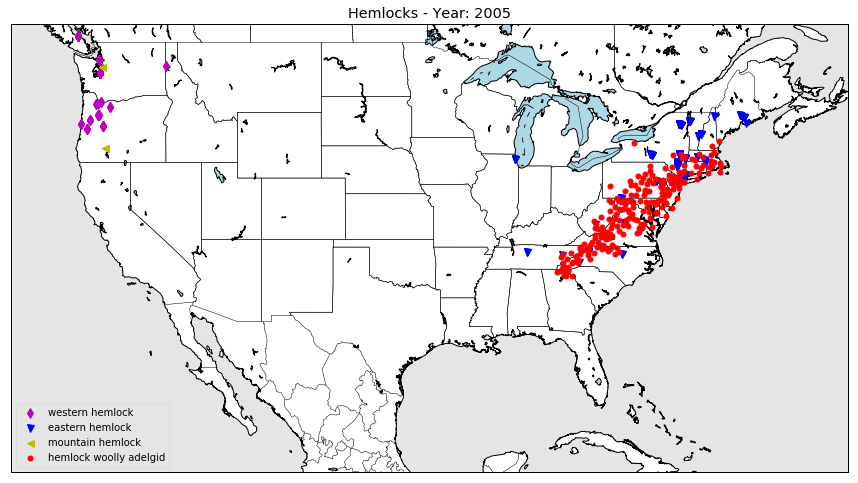

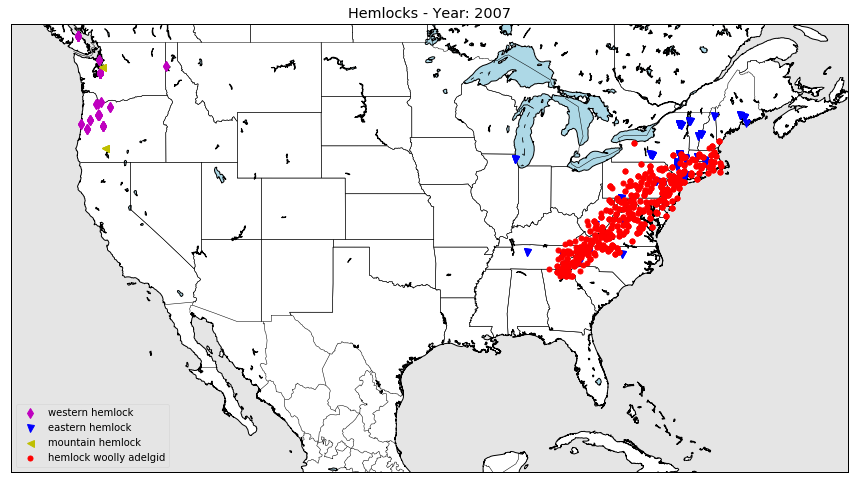

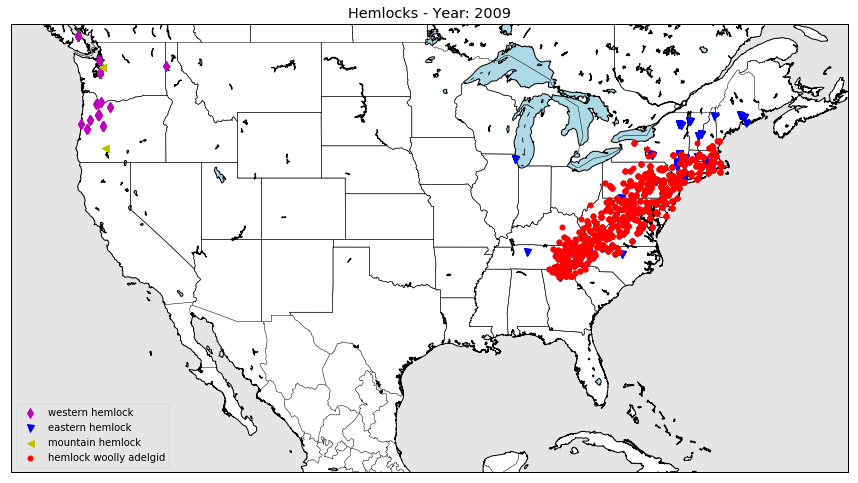

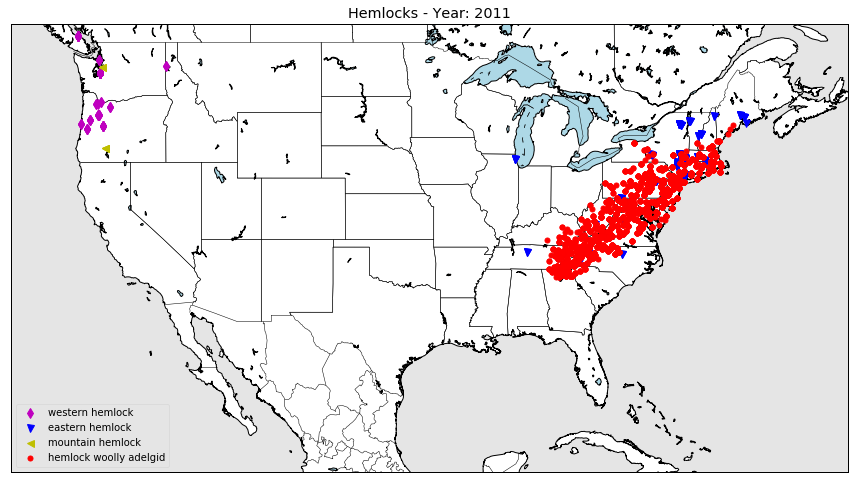

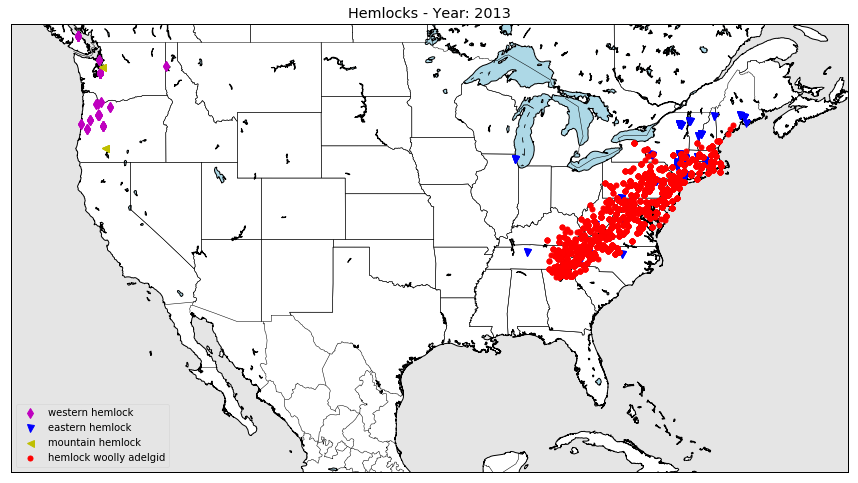

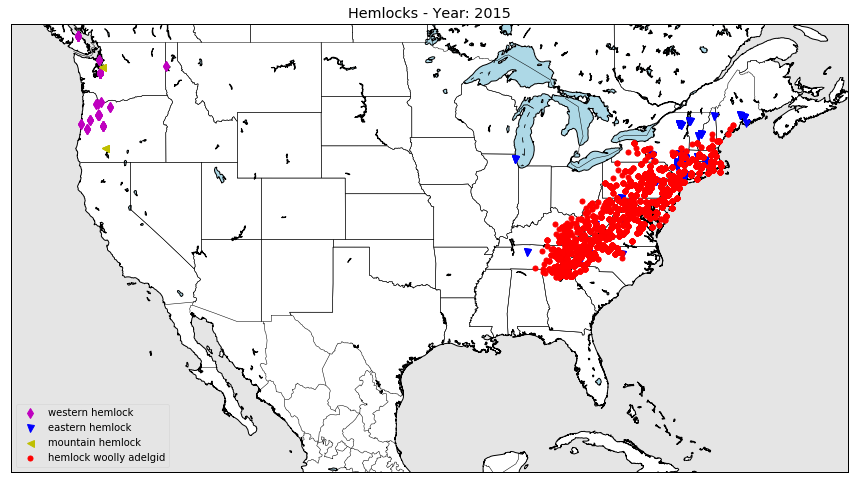

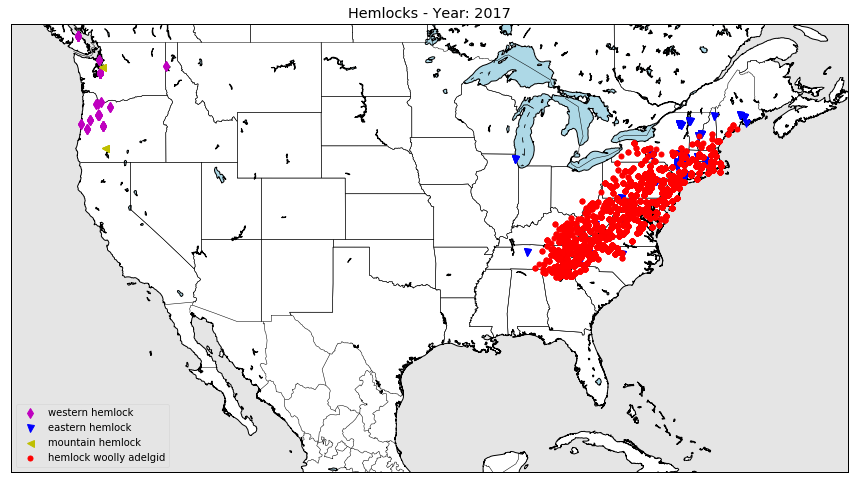

In [7]:
invasives(tree_dataset='tsuga_data.csv',
          invasive_dataset='woolly_data.xlsx',
          state_abbr_dataset='us_states_data.csv',
          lat_long_for_county_dataset='zip_codes_states.csv',
          plant_species_name="Hemlocks",
          start_year = 2003,
          end_year = 2019,
          year_interval = 2)